# **Fit Absorption models to the experimental curve**

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
# Read measured data
pl_meas = pd.read_csv('/content/JC18-02_aging_65C_85RH_43.txt', delimiter='	', decimal=',', header=None, skiprows=5, usecols=[0,2], names=['lambda','counts'])
lambda_thresh = 850
# Take lamda range from 650 to 850
pl_meas = pl_meas[(pl_meas['lambda'] <= 850) & (pl_meas['lambda'] >= 650)]

Lamda peak: 763.421936 (nm)
Energy peak: 1.6242656145002363 (eV)


,lambda,counts,E
375,650.107605,560.0,1.907377
376,650.383362,560.0,1.906568
377,650.658997,551.0,1.905760
378,650.934692,550.0,1.904953
379,651.210388,561.0,1.904147
...,...,...,...
1122,848.753357,903.0,1.460966
1123,849.008728,870.0,1.460527
1124,849.263855,888.0,1.460088
1125,849.519043,873.0,1.459649


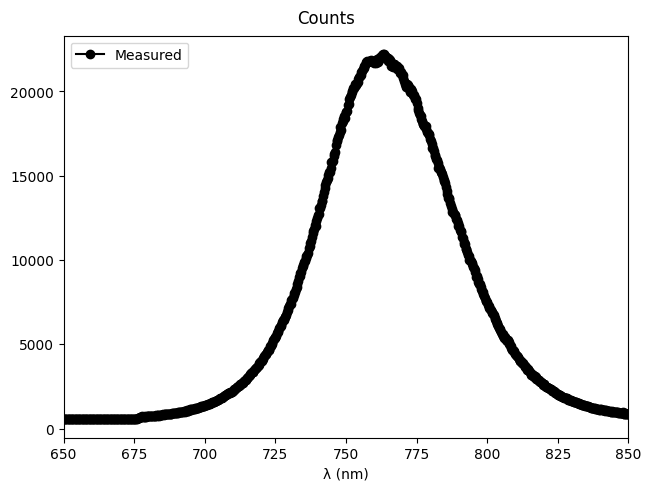

In [42]:
# Compare meas vs sim PL
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(pl_meas['lambda'], pl_meas['counts'], '-o', label='Measured', c='black')
# ax_.plot(Abs['lambda'], Abs['PL'], '-o', label='Simulated')
ax.set_xlabel('λ (nm)')
fig.suptitle('Counts')
ax.set_xlim(650, 850)
ax.legend(loc='upper left')
pl_meas['E'] = 1240/pl_meas['lambda']
max_value_index = pl_meas['counts'].idxmax()
lambda_at_max_counts = pl_meas.loc[max_value_index, 'lambda']
energy_at_max_counts = pl_meas.loc[max_value_index, 'E']
print("Lamda peak:", lambda_at_max_counts, "(nm)")
print("Energy peak:", energy_at_max_counts, "(eV)")
pl_meas

## Katahara model

$$G(E) = \frac{1}{\gamma 2\Gamma (1 + \frac{1}{\theta})} \int_{-\infty}^{\infty (E-E_1)} \left( \exp\left(-\left|\frac{u}{\gamma}\right|^{\theta}\right) \sqrt{E - E_1 - u} \right) du.$$
$$a(E) = 1 - \exp(-\alpha_0 d * G(E)).$$
$$I_{PL}(E) = \frac{2\pi A}{h^3c^2} \frac{E^2 a(E)}{\exp\left(\frac{E - \Delta\mu}{kT}\right) - 1} = \frac{2\pi A}{h^3c^2} \frac{E^2 [1 - \exp(-\alpha_0 d * G(E))]}{\exp\left(\frac{E - \Delta\mu}{kT}\right) - 1}$$

In [ ]:
from scipy.integrate import quad
from scipy.special import gamma as gamma_function
import numpy as np
from scipy.constants import h, c, k
# Constants
h = 6.62607015e-34  # Planck constant (J s)
c = 2.99792458e8    # Speed of light (m/s)
k = 1.380649e-23    # Boltzmann constant (J/K)

# Photocurrent equation
def photocurrent2(E, A, alpha_0d, theta, gamma, E1, Delta_mu):
    # Temperature = 65°C
    T = 273.15 + 65
    eV_to_J = 1.60218e-19  # 1 eV = 1.60218e-19 J
    # Convert energies from eV to Joules
    E = E * eV_to_J
    E1 = E1 * eV_to_J
    Delta_mu = Delta_mu * eV_to_J
    gamma = gamma * eV_to_J

    # Define the model function G(E)
    def G(E, theta, gamma, E1):
        # Define the integrand
        def integrand(u, E, theta, gamma, E1):
            if E - E1 - u > 0:
                return np.exp(-np.abs(u / gamma)**theta) * np.sqrt(E - E1 - u)
            else:
                return 0

        # Initialize the result array
        results = np.zeros_like(E)

        # Iterate over all E values
        for i, E_val in enumerate(np.atleast_1d(E)):
            # Perform the numerical integration for each E value
            integral, _ = quad(integrand, -np.inf, E_val-E1, args=(E_val, theta, gamma, E1))
            constant = 1 / (gamma *2* gamma_function(1 + 1/theta))
            results[i] = constant*integral

        # If E was a scalar, return a scalar result; otherwise, return the array
        if np.isscalar(E):
            return results[0]
        else:
            return results

    # Absorption a(E)
    a_E = 1 - np.exp(-alpha_0d * G(E, theta, gamma, E1))

    # Photocurrent I_PL(E)
    I_PL = (2 * np.pi * A *a_E* E**2 ) / ((h**3 * c**2) * (np.exp((E - Delta_mu) / (k * T)) - 1))

    return I_PL


In [ ]:
from scipy.optimize import curve_fit
# Convert pandas Series to numpy arrays
E_values = pl_meas['E'].values
lambda_values = pl_meas['lambda'].values
count_values = pl_meas['counts'].values
#photocurrent2(E, A, alpha_0d, theta, gamma, E1, Delta_mu):
ini = [2000000,30,1,0.050,1.5,1.1]
# Fit the model to the data
popt, pcov = curve_fit(I_PL, E_values, count_values, p0=ini)
popt

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


array([2.0e+06, 3.0e+01, 1.0e+00, 5.0e-02, 1.5e+00, 1.1e+00])

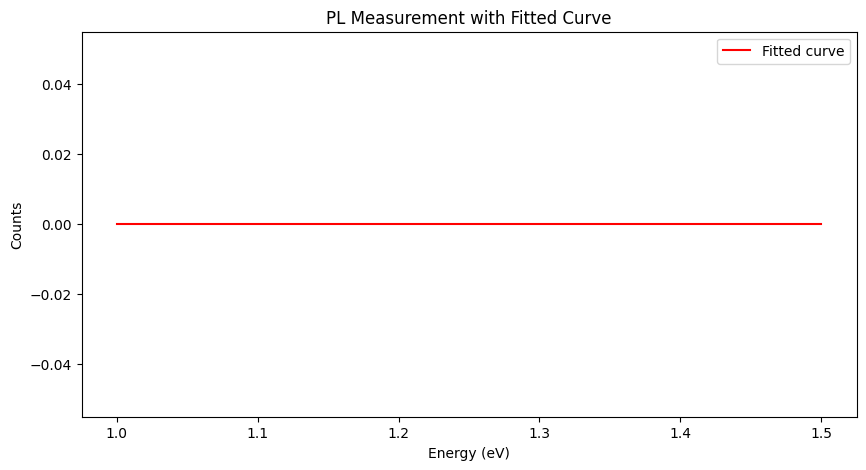

In [ ]:
ini = [2e34,30,1,0.050,1.5,0.0001]
# Generate fitted curve
E_fit = np.linspace(1,1.5, 2)
#counts_fit = G(E_fit, *popt)
counts_fit = photocurrent2(E_fit, *list(ini))

# Plot the measured data
plt.figure(figsize=(10, 5))
# plt.scatter(pl_meas['E'], pl_meas['counts'], label='Measured data', color='blue')

# Plot the fitted curve
plt.plot(E_fit, counts_fit, label='Fitted curve', color='red')

# Label the axes and add a legend
plt.xlabel('Energy (eV)')
plt.ylabel('Counts')
plt.legend()
plt.title('PL Measurement with Fitted Curve')
plt.show()

In [ ]:
print(counts_fit)

[0. 0.]


$$I_{PL}(E) = \frac{2\pi A}{h^3c^2} \frac{E^2 a(E)}{\exp\left(\frac{E - \Delta\mu}{kT}\right) - 1} = B{E^2 [1 - \exp(-\alpha_0 d * G(E))]}\exp\left(\frac{-E}{kT}\right) $$

In [39]:
 E_fit = np.linspace(0.8, 1.4, 200)
 def G(E, theta, gamma, E1):
        # Define the integrand
        def integrand(u, E, theta, gamma, E1):
            if E - E1 - u > 0:
                return np.exp(-np.abs(u / gamma)**theta) * np.sqrt(E - E1 - u)
            else:
                return 0

        # Initialize the result array
        results = np.zeros_like(E)

        # Iterate over all E values
        for i, E_val in enumerate(np.atleast_1d(E)):
            # Perform the numerical integration for each E value
            integral, _ = quad(integrand, -np.inf, E_val-E1, args=(E_val, theta, gamma, E1))
            constant = 1 / (gamma *2* gamma_function(1 + 1/theta))
            results[i] = constant*integral

        # If E was a scalar, return a scalar result; otherwise, return the array
        if np.isscalar(E):
            return results[0]
        else:
            return results
def a(E,alpha0d, theta, gamma, E1):
  return 1 - np.exp(-alpha0d * G(E, theta, gamma, E1))
def I_PL(E,B,alpha0d, theta, gamma, E1):
      T = 273.15 + 65
      k = 1.380649e-23    # Boltzmann constant (J/K)
      eV_to_J = 1.60218e-19  # 1 eV = 1.60218e-19 J
      # Convert energies from eV to Joules
      return B*(E*eV_to_J)**2*np.exp((-E*eV_to_J) / (k * T))*a(E,alpha0d, theta, gamma, E1)


Text(0, 0.5, 'I_PL')

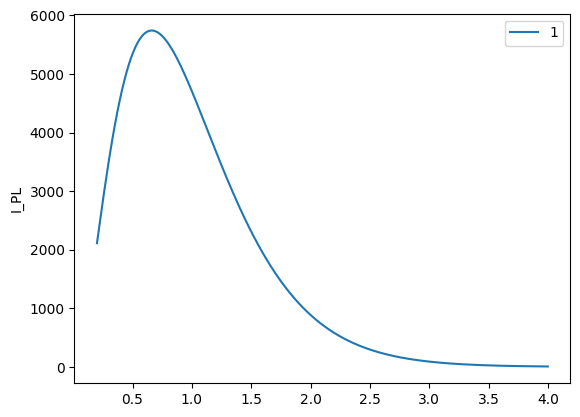

In [81]:
E_fit = np.linspace(0.2, 4, 200)
#Plot a
plt.plot(E_fit,I_PL(E_fit,2.78947413e+43,50, 2, 10,20.1),label = '1')
plt.legend()
plt.ylabel("I_PL")

In [82]:
from scipy.optimize import curve_fit
# Convert pandas Series to numpy arrays
E_values = pl_meas['E'].values
lambda_values = pl_meas['lambda'].values
count_values = pl_meas['counts'].values
#photocurrent2(E, A, alpha_0d, theta, gamma, E1, Delta_mu):
ini = [1e41,30,1, 0.21, 1.6]
# Fit the model to the data
popt, pcov = curve_fit(I_PL, E_values, count_values,bounds=([1e43,30,1, 0, 1.5], [1e45,50,2, 100, 1.7]))
popt

array([2.78947413e+43, 4.00000000e+01, 1.50000000e+00, 5.00000000e+01,
       1.60000000e+00])

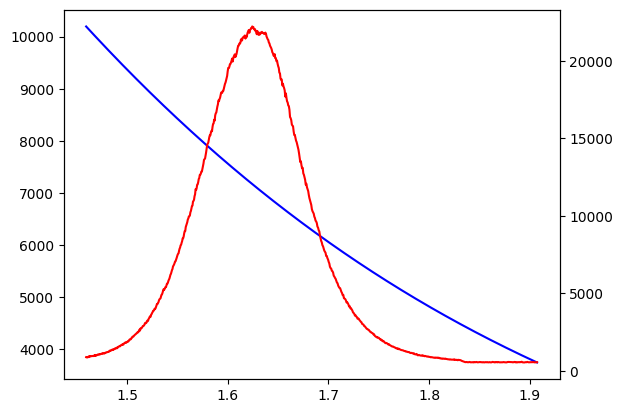

In [62]:
fig, ax = plt.subplots()
ax.plot(E_values,I_PL(E_values,*list(popt)), c = 'blue')
ax_ = ax.twinx()
ax_.plot(E_values,count_values, c='red')